<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Prokhorenko-Evgeniy-folder/Prokhorenko_Evgeniy/10_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка и подготовка данных для подачи в нейронную сеть

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! pip install Augmentor
import Augmentor
import zipfile
import os
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
# Строим график точности на проверочной выборке
import matplotlib.pyplot as plt

# Утилиты предобработки данных
from keras import  utils

# устанавливаем Autokeras
!pip install autokeras
!pip install --upgrade autokeras
import autokeras as ak

from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел 
import tensorflow as tf
'''
это одна из наиболее популярных библиотек машинного обучения и искусственного 
интеллекта. Она используется для создания и обучения различных моделей машинного
обучения, в том числе нейронных сетей.
'''
from sklearn.metrics import confusion_matrix #
!pip install keras-tuner --upgrade
from keras_tuner.applications import HyperResNet
import keras_tuner
%matplotlib inline

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.1/527.1 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 102.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Аугментация изображений для получения больше картинок для обучения нейронной сети

In [ ]:
# Указываем путь к архиву и название папки, в которую нужно распаковать
zip_path = "/content/drive/MyDrive/Iris.zip"
dir_path = "Iris"

# Распаковываем архив
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dir_path)
'''
    Код сначала распакует архив в папку "Iris", затем для каждой подпапки в этой 
    папке создаст генератор аугментации и применит к нему набор аугментационных 
    операций, сохраняя измененные изображения в подпапку с суффиксом "_augmented".
    В каждой папке содержится по 6 изображений
'''

# Применяем аугментацию к каждой папке с изображениями
for folder in os.listdir(dir_path):
    if os.path.isdir(os.path.join(dir_path, folder)):
        # Создаем генератор аугментации для каждой папки
        p = Augmentor.Pipeline(os.path.join(dir_path, folder), output_directory=os.path.join('/content/drive/MyDrive/Iris2', folder))
        # Добавляем операции аугментации
        # Вращение изображения
        p.rotate(probability=0.2, max_left_rotation=5, max_right_rotation=5)
        # увеличение
        #p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
        # Обрезание изображения
        #p.crop_random(probability=0.1, percentage_area=0.2)
        # Изменение яркости
        p.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.2)
        # Изменение сонтрасности
        p.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.2)
        # Применяем аугментацию
        p.sample(45)
        print(folder, '- Аугментация завершена')


# Архивируем данные после проверки визуально, что насоздавала аугментация


In [ ]:
def create_archive(folder_path, archive_path):
    """Функция для создания архива папки"""
    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file))

# Путь до папки с результатами
folder_path = '/content/drive/MyDrive/Iris2'

# Путь до создаваемого архива
archive_path = '/content/drive/MyDrive/Iris2.zip'

# Создание архива
create_archive(folder_path, archive_path)

In [ ]:
# Эта команда распакует архив в папку `/content/Iris/`
!unzip /content/drive/MyDrive/Iris2.zip -d /content/
IMAGE_PATH = '/content/content/drive/MyDrive/Iris2'

Теперь вы можете увидеть, что находится в загруженной базе. Для этого функцией `listdir()` из модуля **os** получите список папок по адресу **IMAGE_PATH**:

In [ ]:
# Получите список папок
os.listdir(IMAGE_PATH)

Здесь видно, что файлы распределены по папкам, при этом названия папок соответствуют именам классов (маркам авто). Поэтому зададим список классов из списка папок. Функция `listdir()` возвращает список папок в неопределенном порядке, поэтому список классов желательно отсортировать, чтобы имена классов всегда шли в одном порядке. Метками классов будут индексы имен классов в списке классов. Количество классов определим как длину списка классов.

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

In [ ]:
i = 0

# Формирование пути к выборке одной марки авто
f'{IMAGE_PATH}{CLASS_LIST[i]}/'

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `imshow()` из модуля **matplotlib.pyplot**).

Для этого импортируем необходимые библиотеки, создадим заготовку для изображений всех классов.

Далее в цикле переберем все классы. Сформируем путь к классу, выберем из него один случайный экземпляр (при помощи функции `random.choice()`) и отобразим его в ячейке (получим содержимое картинки при помощи функции `open()` из модуля **Image**).

In [ ]:
data_dir = "/content/drive/MyDrive/Iris2/"

# Получение списка папок в каталоге
folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# Показ по одной фотографии из каждой папки
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    image_names = [name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]
    if len(image_names) > 0:
        first_image_path = os.path.join(folder_path, image_names[0])
        image = Image.open(first_image_path)
        image.show()

# Изображения

Для выполнения задачи нужно выполнить следующие шаги:

Импортировать модуль os для работы с файловой системой.
Создать два пустых списка: один для хранения путей к файлам изображений, а другой для хранения меток классов (названий папок).
Получить список папок, содержащихся в директории 'construction'.
Для каждой папки пройтись по всем файлам внутри нее и добавить путь к файлу в первый список, а метку (название категории) во второй список.
Вывести на экран количество изображений в каждой папке и имя папки.
Вот код для выполнения всех этих шагов:

In [ ]:
# Создаем пустые списки для хранения путей к файлам изображений и меток классов
image_paths = []
labels = []

# Получаем список папок, содержащихся в директории '/Iris/'
dir_path = "/content/drive/MyDrive/Iris2/"
categories = os.listdir(dir_path)

# Проходим по каждой папке и добавляем в списки путь к файлу изображения и метку класса
for category in categories:
    category_path = os.path.join(dir_path, category)
    if os.path.isdir(category_path):
        files = os.listdir(category_path)
        print(f"Number of images in '{category}': {len(files)}")
        for file_name in files:
            file_path = os.path.join(category_path, file_name)
            image_paths.append(file_path)
            labels.append(category)

# Выводим результаты
print("Total number of images:", len(image_paths))
print("Total number of labels:", len(labels))


In [ ]:

# Создаем экземпляр LabelEncoder и преобразуем лейблы в числовой формат
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# Создаем экземпляр OneHotEncoder и преобразуем числовые значения в One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Выводим результат
print(onehot_encoded)


Этот код сначала создает экземпляр LabelEncoder, который преобразует лейблы в числовой формат. Затем создается экземпляр OneHotEncoder, который преобразует числовые значения в формат One-Hot Encoding. Наконец, преобразованные данные выводятся на экран.

In [ ]:
onehot_encoded[0]

Для выполнения задачи нужно выполнить следующие шаги:

Импортировать модули numpy и Image из библиотеки Pillow.
Создать пустой список для изображений.
Пройтись по списку image_paths, открыв каждое изображение, приведя его к формату 64 на 64 пикселя и добавив его в пустой список в виде numpy массива.
После окончания всех итераций, перевести созданный список в формат numpy массива.
Cписок меток классов  перевести в формат numpy массива.
Вот код для выполнения всех этих шагов:

In [ ]:
# Создаем пустой список для изображений
images128 = []

# Проходим по каждому пути к файлу изображения и добавляем его в список
for path in image_paths:
    with Image.open(path) as img:
        img = img.resize((128, 128)) # изменяем размер изображения до 64x64 пикселей
        img = np.array(img) # приводим изображение к формату numpy массива
        images128.append(img) # добавляем изображение в список

# Преобразуем список в формат numpy массива
images128 = np.array(images128)

# Преобразуем список меток классов в формат numpy массива

labels_onehot128 = np.array(onehot_encoded)

# Выводим размерности массивов с изображениями и метками классов
print("Shape of images array:", images128.shape)
print("Shape of labels array:", labels_onehot128.shape)

images64 = []

# Проходим по каждому пути к файлу изображения и добавляем его в список
for path in image_paths:
    with Image.open(path) as img:
        img = img.resize((64, 64)) # изменяем размер изображения до 64x64 пикселей
        img = np.array(img) # приводим изображение к формату numpy массива
        images64.append(img) # добавляем изображение в список

# Преобразуем список в формат numpy массива
images64 = np.array(images64)

# Преобразуем список меток классов в формат numpy массива

labels_onehot64 = np.array(onehot_encoded)

# Выводим размерности массивов с изображениями и метками классов
print("Shape of images array:", images64.shape)
print("Shape of labels array:", labels_onehot64.shape)


In [ ]:
# Нормируем массив изображений
images_normalized64 = images64 / 255.0

# Выводим результат
print(images_normalized64[0])

# Нормируем массив изображений
images_normalized128 = images128 / 255.0

# Выводим результат
print(images_normalized128[0])

In [ ]:

# Разделяем данные на тренировочную и тестовую выборки
X_Train128, X_val128, y_Train128, y_val128 = train_test_split(images128, labels_onehot128, test_size=0.2, random_state=42)
X_train128, X_test128, y_train128, y_test128 = train_test_split(X_Train128, y_Train128, test_size=0.2, random_state=42)
# Выводим размеры тренировочной и тестовой выборок
print("X_train128 shape:", X_train128.shape)
print("y_train128 shape:", y_train128.shape)
print("X_val128 shape:", X_val128.shape)
print("y_val128 shape:", y_val128.shape)
print("X_test128 shape:", X_test128.shape)
print("y_test128 shape:", y_test128.shape)


In [ ]:
# Разделяем данные на тренировочную и тестовую выборки
X_Train64, X_val64, y_Train64, y_val64 = train_test_split(images64, labels_onehot64, test_size=0.2, random_state=42)
X_train64, X_test64, y_train64, y_test64 = train_test_split(X_Train64, y_Train64, test_size=0.2, random_state=42)
# Выводим размеры тренировочной и тестовой выборок
print("X_train shape:", X_train64.shape)
print("y_train shape:", y_train64.shape)
print("X_val shape:", X_val64.shape)
print("y_val shape:", y_val64.shape)
print("X_test shape:", X_test64.shape)
print("y_test shape:", y_test64.shape)


# Cохранение и дальнейшая загрузка данных для создания нейронных сетей 

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/X_train128'    , X_train128)
np.save('/content/drive/MyDrive/Colab Notebooks/y_train128'    , y_train128)
np.save('/content/drive/MyDrive/Colab Notebooks/X_val128'      , X_val128)
np.save('/content/drive/MyDrive/Colab Notebooks/y_val128'      , y_val128)
np.save('/content/drive/MyDrive/Colab Notebooks/X_test128'     , X_test128)
np.save('/content/drive/MyDrive/Colab Notebooks/y_test128'     , y_test128)

np.save('/content/drive/MyDrive/Colab Notebooks/X_train64'    , X_train64)
np.save('/content/drive/MyDrive/Colab Notebooks/y_train64'    , y_train64)
np.save('/content/drive/MyDrive/Colab Notebooks/X_val64'      , X_val64)
np.save('/content/drive/MyDrive/Colab Notebooks/y_val64'      , y_val64)
np.save('/content/drive/MyDrive/Colab Notebooks/X_test64'     , X_test64)
np.save('/content/drive/MyDrive/Colab Notebooks/y_test64'     , y_test64)

In [ ]:
print("X_train shape:", X_train64.shape)
print("y_train shape:", y_train64.shape)
print("X_val shape:", X_val64.shape)
print("y_val shape:", y_val64.shape)
print("X_test shape:", X_test64.shape)
print("y_test shape:", y_test64.shape)

In [ ]:
X_train128 =             np.load('/content/drive/MyDrive/Colab Notebooks/X_train128.npy')
y_train128 =             np.load('/content/drive/MyDrive/Colab Notebooks/y_train128.npy')
X_val128   =             np.load('/content/drive/MyDrive/Colab Notebooks/X_val128.npy')
y_val128   =             np.load('/content/drive/MyDrive/Colab Notebooks/y_val128.npy')
X_test128  =             np.load('/content/drive/MyDrive/Colab Notebooks/X_test128.npy')
y_test128  =             np.load('/content/drive/MyDrive/Colab Notebooks/y_test128.npy')

X_train64  =             np.load('/content/drive/MyDrive/Colab Notebooks/X_train64.npy')
y_train64  =             np.load('/content/drive/MyDrive/Colab Notebooks/y_train64.npy')
X_val64    =             np.load('/content/drive/MyDrive/Colab Notebooks/X_val64.npy')
y_val64    =             np.load('/content/drive/MyDrive/Colab Notebooks/y_val64.npy')
X_test64   =             np.load('/content/drive/MyDrive/Colab Notebooks/X_test64.npy')
y_test64   =             np.load('/content/drive/MyDrive/Colab Notebooks/y_test64.npy')

In [ ]:

# Создаем модель нейронной сети
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='softmax'))

# Компилируем модель
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем модель на тренировочной выборке
history = model.fit(X_train128, y_train128, epochs=20, validation_data=(X_val128, y_val128))

# Строим график точности на проверочной выборке
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()


In [ ]:
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

In [ ]:
# Оценка точности модели на проверочной выборке
accuracy = model.evaluate(X_test128, y_test128)[1]
print("Accuracy on validation data:", accuracy)

In [ ]:

# Создаем модель нейронной сети
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='softmax'))

# Компилируем модель
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем модель на тренировочной выборке
history = model.fit(X_train64, y_train64, epochs=20, validation_data=(X_val64, y_val64))

# Вывод модели 
utils.plot_model(model, dpi=60)

plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()



In [ ]:
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

In [ ]:
# Оценка точности модели на проверочной выборке
accuracy = model.evaluate(X_test64, y_test64)[1]
print("Accuracy on validation data:", accuracy)

In [ ]:


# Инициализация классификатора AutoKeras
clf = ak.ImageClassifier(
    max_trials=4,
    objective='val_accuracy',
    directory='pavement_crack',
    overwrite=True)

clf.fit(X_train64, y_train64, epochs=14, validation_data=(X_val64, y_val64))
clf.export_model().to_saved_model('model')

##Получаем архитектуру модели и используемые в ней параметры

In [ ]:
best_model = clf.export_model()
best_model.summary()

In [ ]:
# Оценка точности модели на проверочной выборке
accuracy = best_model.evaluate(X_test64, y_test64)[1]
print("Accuracy on validation data:", accuracy)

In [ ]:

clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=10,
    objective="val_accuracy"
)

clf.fit(
    X_train64,
    y_train64,
    validation_data=(X_val64, y_val64),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    )]
)

clf.export_model().to_saved_model('model')

In [ ]:

clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=10,
    objective="val_accuracy"
)

clf.fit(
    X_train64,
    y_train64,
    validation_data=(X_val64, y_val64),
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True
    )]
)
clf.export_model().to_saved_model('model')

In [ ]:
best_model = clf.export_model()
best_model.summary()

In [ ]:
# Оценка точности модели на проверочной выборке
accuracy = best_model.evaluate(X_test64, y_test64)[1]
print("Accuracy on validation data:", accuracy)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# преобразование мультиклассовых меток в мультиэтикеточные
encoder = OneHotEncoder()
y_test64_encoded = encoder.fit_transform(y_test64) 
# определенин `inputs` и `outputs`:

input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ConvBlock()(output_node)
output_node = ak.DenseBlock()(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(inputs=input_node, outputs=output_node, overwrite=True, 
                   max_trials=10, objective='val_loss')
'''
В данном примере мы создаем `input_node` с помощью метода `ImageInput()`, 
а затем поочередно применяем блоки для нормализации, сверточных слоев, 
плотных слоев и блок для классификации, чтобы определить выходной узел 
`output_node`.
'''

clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=10,
    objective="val_accuracy"
)

clf.fit(
    X_train64,
    y_train64,
    validation_data=(X_val64, y_val64),
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True
    )]
)

# Сохранение модели в формате Tensorflow SavedModel
clf.export_model().save('/content/drive/MyDrive/model_1')


Trial 10 Complete [00h 02m 18s]
val_accuracy: 0.9878472089767456

Best val_accuracy So Far: 0.9947916865348816
Total elapsed time: 00h 13m 12s


15/15 [==============================] - 0s 13ms/step - loss: 0.0434 - accuracy: 0.9935
Accuracy on test data: 99.35%


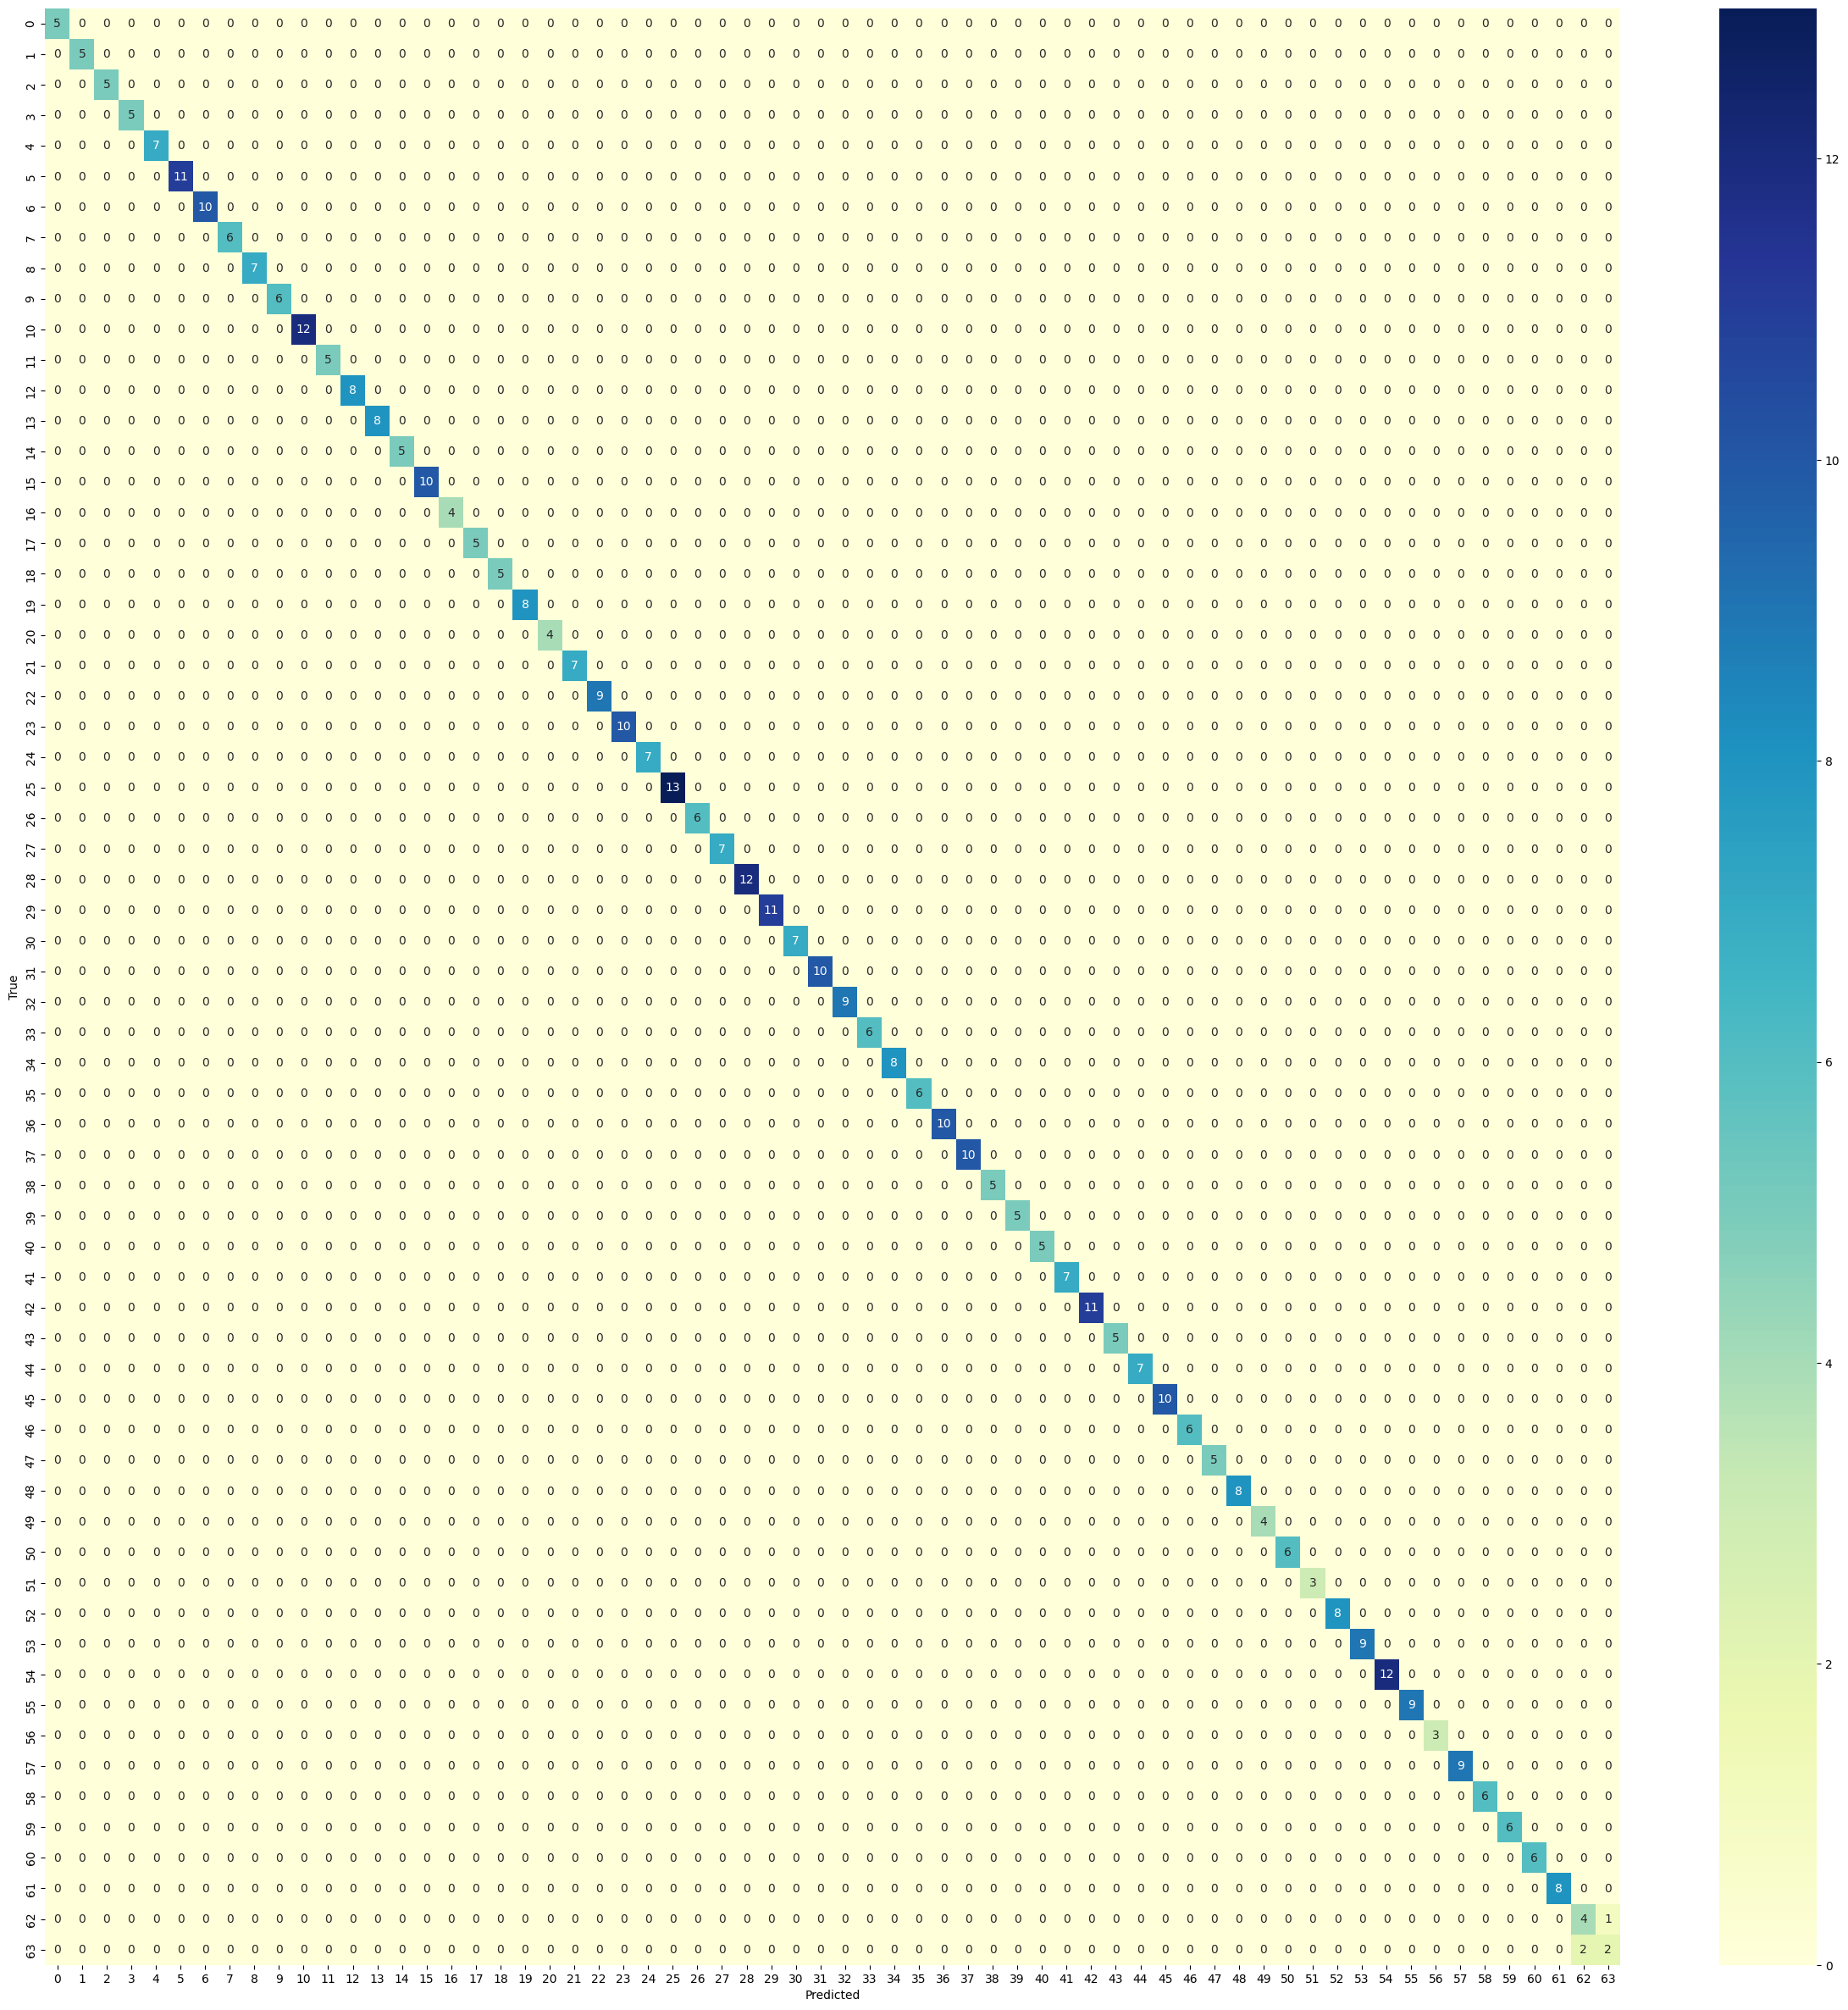

In [ ]:
#1. Загрузите сохраненную модель:
model = tf.keras.models.load_model('/content/drive/MyDrive/model_1')
#2. Выполните предсказания на тестовой выборке:
y_pred = model.predict(X_test64)
#3. Вычислите точность (accuracy) на тестовой выборке:
accuracy = model.evaluate(X_test64, y_test64)[1]
print("Accuracy on test data: {:.2%}".format(accuracy))
#4. Вычислите матрицу ошибок:
y_test64_classes = [tf.argmax(y_test64[i]).numpy() for i in range(len(y_test64))]
y_pred_classes = [tf.argmax(y_pred[i]).numpy() for i in range(len(y_pred))]
confusion_mtx = confusion_matrix(y_test64_classes, y_pred_classes)
#5. Отобразите матрицу ошибок в графическом виде:
plt.figure(figsize=(30,30))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 64, 64, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 64, 64, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 512)       147968    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 512)      0     

In [ ]:
# Оценка точности модели на проверочной выборке
accuracy = model.evaluate(X_test64, y_test64)[1]
print("Accuracy on validation data:", accuracy)

15/15 [==============================] - 0s 17ms/step - loss: 0.0434 - accuracy: 0.9935
Accuracy on validation data: 0.9934924244880676


#Авто керас


In [ ]:
from keras.callbacks import EarlyStopping 

In [ ]:
hypermodel = HyperResNet(input_shape=(64, 64, 3), classes=64)

tuner3 = keras_tuner.RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=4,
    overwrite=True,
    directory="my_dir",
    project_name="ResNet",
)

# Добавляем остановку если нет изменений 
earlystop = EarlyStopping(monitor='val_accuracy', patience=5)

tuner3.search(X_train64, y_train64, epochs=50, validation_data=(X_val64, y_val64), callbacks=[earlystop])

# Получите лучшую модель
best_model = tuner3.get_best_models(num_models=1)[0]

# Оцените модель на Тестовой выборке
accuracy = best_model.evaluate(X_test64, y_test64)[1]
print("Accuracy on validation data:", accuracy)

Trial 4 Complete [00h 06m 08s]
val_accuracy: 0.7291666865348816

Best val_accuracy So Far: 0.8871527910232544
Total elapsed time: 00h 18m 49s
15/15 [==============================] - 4s 67ms/step - loss: 0.5495 - accuracy: 0.8568
Accuracy on validation data: 0.8568329811096191
